In [124]:
import torch
import torchviz
from torch import nn
import torch.nn.functional as F
from torch import tensor
from torch.nn import Linear,ReLU,Sigmoid,Tanh
import torch.optim as optim
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.metrics import r2_score,mean_squared_error
from math import sqrt
import joblib
from torch.utils.tensorboard import SummaryWriter
import warnings;warnings.simplefilter('ignore')
from tqdm import tqdm_notebook as tqdm
import os
from sklearn.utils import shuffle
import random
random.seed(42)
torch.manual_seed(42)
root = '../data/phase_2/cleaned/'
os.listdir(root)

['col_names.pkl', 'train.csv', 'train(energy).csv']

In [125]:
col_names = joblib.load(root+'col_names.pkl')
col_names.keys()

dict_keys(['xna', 'xle', 'xhc', 'xhe', 'fna', 'fle', 'fhc', 'fhe', 'sle', 'shc', 'she', 'case', 'duty', 'Rate_m3', 'Rate_ton'])

# some function

In [126]:
def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def get_group_col(df,name):
    condition = df.columns.str.contains(name)
    return df.columns[condition].tolist()

# load data

In [127]:
df = pd.read_csv(root+'train.csv',index_col=0)
print(df.shape)
df.head()

(16498, 386)


,Case Conditions_Feed Rate to C013 (Input)_m3/hr,Case Conditions_Heart Cut Prod. Rate (Input)_m3/hr,Case Conditions_C7+ in Light End (Input)_wt%,Case Conditions_C6P- in Heart Cut (Input)_wt%,Naphtha Properties_Oxygen_wt%,Naphtha Properties_Methane_wt%,Naphtha Properties_Ethane_wt%,Naphtha Properties_Propane_wt%,Naphtha Properties_n-Butane_wt%,Naphtha Properties_i-Pentane_wt%,...,"Individual Component to Heavy End Split Factor_2,2,3,3-Tetramethylhexane_Ratio",Individual Component to Heavy End Split Factor_3-Methylnonane_Ratio,Individual Component to Heavy End Split Factor_tert-Butylcyclohexane_Ratio,Individual Component to Heavy End Split Factor_n-Decane_Ratio,"Individual Component to Heavy End Split Factor_1,2-Diethylbenzene_Ratio",Individual Component to Heavy End Split Factor_n-Undecane_Ratio,Individual Component to Heavy End Split Factor_n-Pentylbenzene_Ratio,Individual Component to Heavy End Split Factor_n-Dodecane_Ratio,Individual Component to Heavy End Split Factor_n-Hexylbenzene_Ratio,Individual Component to Heavy End Split Factor_n-Tridecane_Ratio
001-01,10.0,100.0,2.5,1.0,0.0,0.0,0.0,0.002,0.003,0.025999,...,0.348342,0.378793,0.381912,0.397334,0.409138,0.433925,0.440811,0.451332,0.454764,1.0
001-02,10.0,100.0,5.0,1.0,0.0,0.0,0.0,0.002,0.003,0.025999,...,0.336983,0.367462,0.370631,0.386031,0.397878,0.422758,0.429677,0.440263,0.443717,1.0
001-03,10.0,100.0,10.0,1.0,0.0,0.0,0.0,0.002,0.003,0.025999,...,0.323372,0.354403,0.357728,0.373260,0.385311,0.410579,0.417606,0.428374,0.431884,1.0
001-04,10.0,100.0,2.5,1.5,0.0,0.0,0.0,0.002,0.003,0.025999,...,0.334064,0.360351,0.362654,0.376680,0.387033,0.409416,0.415640,0.425230,0.428354,1.0
001-05,10.0,100.0,5.0,1.5,0.0,0.0,0.0,0.002,0.003,0.025999,...,0.323809,0.350009,0.352356,0.366307,0.376672,0.399048,0.405285,0.414893,0.418027,1.0


# define columns

In [128]:
case_col = col_names['case']
case_col

['Case Conditions_Feed Rate to C013 (Input)_m3/hr',
 'Case Conditions_Heart Cut Prod. Rate (Input)_m3/hr',
 'Case Conditions_C7+ in Light End (Input)_wt%',
 'Case Conditions_C6P- in Heart Cut (Input)_wt%']

In [129]:
naphtha_col = col_names['xna']
print(len(naphtha_col))
naphtha_col[0],naphtha_col[-1]

54


('Naphtha Properties_Oxygen_wt%', 'Naphtha Properties_n-Tridecane_wt%')

In [130]:
s_col = col_names['sle'] + col_names['shc'] + col_names['she']
print(len(s_col))

162


# sorted s_col

In [131]:
temp = []
for i in range(54):
    temp = temp+s_col[i:162+1:54]
s_col = temp
print(len(s_col))

162


# 3d scatter

In [132]:
color_col = get_group_col(df,'P-Xylene')[-3:]
color_col

['Individual Component to Light End Split Factor_P-Xylene_Ratio',
 'Individual Component to Heart Cut Split Factor_P-Xylene_Ratio',
 'Individual Component to Heavy End Split Factor_P-Xylene_Ratio']

In [133]:
plot_data = df.sample(1000)
for i in range(3):
    fig = px.scatter_3d(plot_data, 
                        x = case_col[0], 
                        y = case_col[1], 
                        z = case_col[2],
                        color = color_col[i])
    fig.show()

# save fig

In [134]:
#import chart_studio
#import chart_studio.plotly as py
#username = 'skywalker0803r' # your username
#api_key = 'CLGvsK8xFJCsJtm8Tzwr' # your api key - go to profile > settings > regenerate key
#chart_studio.tools.set_credentials_file(username=username, api_key=api_key)
#py.plot(fig, filename = 'split_factor', auto_open=True)

# build scaler

In [135]:
x_col = case_col + naphtha_col
y_col = s_col
ss = StandardScaler().fit(df[x_col])

#  features scale

In [136]:
df[x_col] = ss.transform(df[x_col])

# split train test

In [137]:
df = shuffle(df)

X = df[x_col]
Y = df[y_col]

sp1 = int(len(X)*0.8)
sp2 = int(len(X)*0.9)

X_train,Y_train = X.iloc[:sp1,:],Y.iloc[:sp1,:]
X_valid,Y_valid = X.iloc[sp1:sp2,:],Y.iloc[sp1:sp2,:]
X_test,Y_test = X.iloc[sp2:,:],Y.iloc[sp2:,:]
test_idx = X_test.index

print(X_train.shape)
print(Y_train.shape)

(13198, 58)
(13198, 162)


# to torch tensor

In [138]:
X_train = torch.tensor(X_train.values,dtype=torch.float).cuda()
X_valid = torch.tensor(X_valid.values,dtype=torch.float).cuda()
X_test = torch.tensor(X_test.values,dtype=torch.float).cuda()

Y_train = torch.tensor(Y_train.values,dtype=torch.float).cuda()
Y_valid = torch.tensor(Y_valid.values,dtype=torch.float).cuda()
Y_test = torch.tensor(Y_test.values,dtype=torch.float).cuda()

In [139]:
print(X_train.shape)
print(Y_train.shape)

torch.Size([13198, 58])
torch.Size([13198, 162])


# data_iter

In [140]:
datasets = torch.utils.data.TensorDataset(X_train, Y_train)
train_iter = torch.utils.data.DataLoader(datasets, batch_size=256, shuffle=True)

In [141]:
datasets = torch.utils.data.TensorDataset(X_valid, Y_valid)
valid_iter = torch.utils.data.DataLoader(datasets, batch_size=256, shuffle=True)

# Construct the neural network

In [142]:
class Dual_net(nn.Module):
    def __init__(self):
        super(Dual_net,self).__init__()
        C_in = 4
        C_out = 3
        N_in = 54
        N_out = 54
        F_in = C_out+N_out
        F_out = C_out+N_out
        O_out = 3
        
        # build C,N,F
        self.C_net = self._build_C_net(C_in,C_out)
        self.N_net = self._build_N_net(N_in,N_out) 
        self.F_net = self._build_F_net(F_in,F_out)
        
        # build O_net
        for i in range(54):
            setattr(self,'O_net{}'.format(i+1),self._build_O_net(F_out,O_out))
        
        # initialize weight
        self.apply(self._init_weights)
            
    def forward(self,x):
        c,n = self._Fetch(x)
        c,n = self.C_net(c),self.N_net(n)
        f = torch.cat((c,n),dim=1)
        f = self.F_net(f)
        output = torch.tensor([]).cuda()
        for i in range(54):
            O_net = getattr(self,'O_net{}'.format(i+1))
            v = F.sigmoid(O_net(f))
            output = torch.cat((output,v),dim=1)
        return output
    
    @staticmethod
    def _Fetch(x):
        return x[:,:4],x[:,4:]
    
    @staticmethod
    def _build_C_net(input_shape,output_shape):
        net = torch.nn.Sequential(
            Linear(input_shape,128),
            Tanh(),
            Linear(128,output_shape))
        return net.cuda()
    
    @staticmethod
    def _build_N_net(input_shape,output_shape):
        net = torch.nn.Sequential(
            Linear(input_shape,128),
            Tanh(),
            Linear(128,output_shape))
        return net.cuda()
    
    @staticmethod
    def _build_F_net(input_shape,output_shape):
        net = torch.nn.Sequential(
            Linear(input_shape,128),
            Tanh(),
            Linear(128,output_shape))
        return net.cuda()
    
    @staticmethod
    def _build_O_net(input_shape,output_shape):
        net = torch.nn.Sequential(
            Linear(input_shape,128),
            Tanh(),
            Linear(128,output_shape))
        return net.cuda()
    
    @staticmethod
    def _init_weights(m):
        if hasattr(m,'weight'):
            torch.nn.init.xavier_uniform(m.weight)
        if hasattr(m,'bias'):
            m.bias.data.fill_(0)

In [143]:
net = Dual_net().cuda()

# forward test

In [144]:
y = net(X_test)
print(y.shape)
y[0].detach().cpu().numpy().sum()

torch.Size([1650, 162])


77.15419

# torchviz

In [145]:
#y = net(X_test)
#dot = torchviz.make_dot(y.mean(),params=dict(net.named_parameters()))
#dot.render("./data/model_2.png")

# tensorboard

In [146]:
#with SummaryWriter(comment='Net')as w:
#    w.add_graph(net, (X_test,))

# loss_function and optimizer

In [147]:
loss_function = nn.MSELoss()
optimizer = optim.Adam(net.parameters(),lr=0.001)

# train_loop

In [148]:
def train(net,train_iter,valid_iter,loss_function,optimizer,num_epochs=100):
    train_history = []
    valid_history = []
    best_loss = np.inf
    best_net = None
    
    for epoch in range(num_epochs):
        # train
        net.train()
        train_loss = 0
        t = 0
        for x,y in train_iter:
            loss = loss_function(net(x),y)
            # weight update
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            # record loss
            train_loss += loss.item()
            t += 1
        train_history.append(train_loss/t)
        
        # eval
        net.eval()
        valid_loss = 0
        t = 0
        for x,y in valid_iter:
            loss = loss_function(net(x),y)
            # record loss
            valid_loss += loss.item()
            t += 1
        valid_history.append(valid_loss/t)
        
        # print the epoch loss
        print("epochs {} train loss {:.4f} valid loss {:.4f}".format(
            epoch,train_history[-1],valid_history[-1]))
        
        # record best_net
        if valid_history[-1] <= best_loss:
            best_loss = valid_history[-1]
            best_net = net
            print('record net')
    
    # when end all epoch plot history
    plt.plot(np.array(train_history),label='train')
    plt.plot(np.array(valid_history),label='valid')
    plt.title('loss history')
    plt.legend()
    plt.show()
    
    # return best_net
    return best_net.eval()

epochs 0 train loss 0.0438 valid loss 0.0026
record net
epochs 1 train loss 0.0021 valid loss 0.0016
record net
epochs 2 train loss 0.0013 valid loss 0.0012
record net
epochs 3 train loss 0.0011 valid loss 0.0009
record net
epochs 4 train loss 0.0008 valid loss 0.0008
record net
epochs 5 train loss 0.0007 valid loss 0.0006
record net
epochs 6 train loss 0.0006 valid loss 0.0005
record net
epochs 7 train loss 0.0005 valid loss 0.0005
record net
epochs 8 train loss 0.0005 valid loss 0.0004
record net
epochs 9 train loss 0.0004 valid loss 0.0004
record net
epochs 10 train loss 0.0004 valid loss 0.0004
record net
epochs 11 train loss 0.0004 valid loss 0.0003
record net
epochs 12 train loss 0.0003 valid loss 0.0003
record net
epochs 13 train loss 0.0003 valid loss 0.0003
record net
epochs 14 train loss 0.0003 valid loss 0.0003
record net
epochs 15 train loss 0.0003 valid loss 0.0003
record net
epochs 16 train loss 0.0003 valid loss 0.0003
record net
epochs 17 train loss 0.0002 valid loss 0.

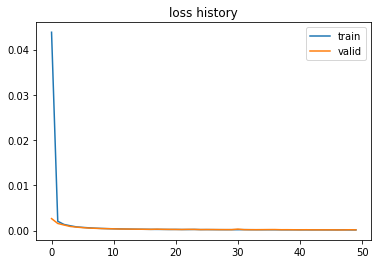

In [149]:
net = train(net,train_iter,valid_iter,loss_function,optimizer,num_epochs=50)

# make prediction

In [150]:
import time
s = time.time()
y_pred = net(X_test).cpu().detach().numpy()
origin_pred_time = time.time()-s
print('原始預測時間:',origin_pred_time)
y_pred = pd.DataFrame(y_pred,columns=y_col)
y_real = Y_test.cpu().detach().numpy()
y_real = pd.DataFrame(y_real,columns=y_col)

原始預測時間: 0.008698463439941406


In [151]:
y_pred.head()

,Individual Component to Light End Split Factor_Oxygen_Ratio,Individual Component to Heart Cut Split Factor_Oxygen_Ratio,Individual Component to Heavy End Split Factor_Oxygen_Ratio,Individual Component to Light End Split Factor_Methane_Ratio,Individual Component to Heart Cut Split Factor_Methane_Ratio,Individual Component to Heavy End Split Factor_Methane_Ratio,Individual Component to Light End Split Factor_Ethane_Ratio,Individual Component to Heart Cut Split Factor_Ethane_Ratio,Individual Component to Heavy End Split Factor_Ethane_Ratio,Individual Component to Light End Split Factor_Propane_Ratio,...,Individual Component to Heavy End Split Factor_n-Pentylbenzene_Ratio,Individual Component to Light End Split Factor_n-Dodecane_Ratio,Individual Component to Heart Cut Split Factor_n-Dodecane_Ratio,Individual Component to Heavy End Split Factor_n-Dodecane_Ratio,Individual Component to Light End Split Factor_n-Hexylbenzene_Ratio,Individual Component to Heart Cut Split Factor_n-Hexylbenzene_Ratio,Individual Component to Heavy End Split Factor_n-Hexylbenzene_Ratio,Individual Component to Light End Split Factor_n-Tridecane_Ratio,Individual Component to Heart Cut Split Factor_n-Tridecane_Ratio,Individual Component to Heavy End Split Factor_n-Tridecane_Ratio
0,0.999749,0.000269,0.000159,0.999733,0.000375,0.000134,0.999574,0.000246,0.000727,0.986535,...,0.376816,2.435878e-07,0.613747,0.385650,0.005317,0.600838,0.381349,0.000386,0.000285,0.999554
1,0.999814,0.000197,0.000152,0.999636,0.000307,0.000208,0.999691,0.000198,0.000435,0.992959,...,0.421153,6.810557e-06,0.561473,0.435557,0.000533,0.569750,0.448909,0.000315,0.000279,0.999697
2,0.999716,0.000669,0.000343,0.999216,0.000488,0.000545,0.999365,0.000440,0.000994,0.987063,...,0.544654,3.994072e-08,0.449798,0.552947,0.010439,0.460777,0.562202,0.000998,0.000520,0.999335
3,0.999686,0.000224,0.000293,0.999546,0.000548,0.000505,0.999375,0.000330,0.000391,0.986794,...,0.514301,2.216400e-05,0.485968,0.536019,0.003206,0.478462,0.526427,0.000546,0.000467,0.999518
4,0.999785,0.000221,0.000212,0.999628,0.000438,0.000243,0.999573,0.000236,0.000520,0.989976,...,0.450941,5.447850e-06,0.542336,0.463804,0.001559,0.542900,0.462478,0.000452,0.000297,0.999629


In [152]:
y_real.head()

,Individual Component to Light End Split Factor_Oxygen_Ratio,Individual Component to Heart Cut Split Factor_Oxygen_Ratio,Individual Component to Heavy End Split Factor_Oxygen_Ratio,Individual Component to Light End Split Factor_Methane_Ratio,Individual Component to Heart Cut Split Factor_Methane_Ratio,Individual Component to Heavy End Split Factor_Methane_Ratio,Individual Component to Light End Split Factor_Ethane_Ratio,Individual Component to Heart Cut Split Factor_Ethane_Ratio,Individual Component to Heavy End Split Factor_Ethane_Ratio,Individual Component to Light End Split Factor_Propane_Ratio,...,Individual Component to Heavy End Split Factor_n-Pentylbenzene_Ratio,Individual Component to Light End Split Factor_n-Dodecane_Ratio,Individual Component to Heart Cut Split Factor_n-Dodecane_Ratio,Individual Component to Heavy End Split Factor_n-Dodecane_Ratio,Individual Component to Light End Split Factor_n-Hexylbenzene_Ratio,Individual Component to Heart Cut Split Factor_n-Hexylbenzene_Ratio,Individual Component to Heavy End Split Factor_n-Hexylbenzene_Ratio,Individual Component to Light End Split Factor_n-Tridecane_Ratio,Individual Component to Heart Cut Split Factor_n-Tridecane_Ratio,Individual Component to Heavy End Split Factor_n-Tridecane_Ratio
0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.992934,...,0.363072,0.0,0.628937,0.371063,0.0,0.625542,0.374458,0.0,0.0,1.0
1,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.995091,...,0.418012,0.0,0.572779,0.427221,0.0,0.568342,0.431658,0.0,0.0,1.0
2,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.987250,...,0.524696,0.0,0.463572,0.536427,0.0,0.458878,0.541122,0.0,0.0,1.0
3,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.987056,...,0.505958,0.0,0.486928,0.513072,0.0,0.483917,0.516083,0.0,0.0,1.0
4,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.990706,...,0.446864,0.0,0.545230,0.454770,0.0,0.541239,0.458761,0.0,0.0,1.0


# metric

In [153]:
res = pd.DataFrame(index=y_col,columns=['MSE','MAPE'])

for i in y_col:
    res.loc[i,'MSE'] = mean_squared_error(y_real[i],y_pred[i])
    res.loc[i,'MAPE'] = mape(y_real[i],y_pred[i])
res = res.sort_values(by='MSE',ascending=False)
res.loc['AVG'] = res.mean(axis=0)
res

,MSE,MAPE
Individual Component to Light End Split Factor_n-Hexylbenzene_Ratio,0.00200204,inf
Individual Component to Heart Cut Split Factor_n-Hexylbenzene_Ratio,0.000791019,inf
Individual Component to Light End Split Factor_n-Hexane_Ratio,0.000744939,2.14897
Individual Component to Heart Cut Split Factor_n-Hexane_Ratio,0.000731704,5.8014
Individual Component to Heavy End Split Factor_n-Hexylbenzene_Ratio,0.000731514,inf
...,...,...
Individual Component to Heavy End Split Factor_tr2-Hexene_Ratio,3.417e-08,inf
Individual Component to Light End Split Factor_tert-Butylcyclohexane_Ratio,2.27941e-08,4.7634e+21
"Individual Component to Light End Split Factor_2,2,3,3-Tetramethylhexane_Ratio",2.25008e-08,3.8057e+19
"Individual Component to Light End Split Factor_1,3,5-Trimethylbenzene_Ratio",1.85762e-08,5.16929e+21


#  wrap model

In [154]:
n_col = naphtha_col

In [155]:
class ANN_wrapper(object):
    def __init__(self,x_col,y_col,n_col,scaler,net):
        self.x_col = x_col
        self.y_col = y_col
        self.n_col = n_col
        self.scaler = scaler
        self.net = net
    
    def predict(self,x):
        x = self.scaler.transform(x)
        x = torch.tensor(x,dtype=torch.float).cuda()
        y = self.net(x).detach().cpu().numpy()
        y = pd.DataFrame(y,columns=self.y_col)
        y = self.normalize(y)
        return y
    
    def normalize(self,y):
        for i in range(0,162+1-3,3):
            col3 = self.y_col[i:i+3]
            assert len(col3) == 3
            y[col3] = y[col3].values / y[col3].sum(axis=1).values.reshape(-1,1)
        return y

In [156]:
model = ANN_wrapper(x_col,y_col,n_col,ss,net.eval())

# test ANN_wrapper

In [165]:
data = pd.read_csv(root+'train.csv',index_col=0).loc[test_idx,:]
x = data[x_col]
y_real = data[y_col]
x.head()

,Case Conditions_Feed Rate to C013 (Input)_m3/hr,Case Conditions_Heart Cut Prod. Rate (Input)_m3/hr,Case Conditions_C7+ in Light End (Input)_wt%,Case Conditions_C6P- in Heart Cut (Input)_wt%,Naphtha Properties_Oxygen_wt%,Naphtha Properties_Methane_wt%,Naphtha Properties_Ethane_wt%,Naphtha Properties_Propane_wt%,Naphtha Properties_n-Butane_wt%,Naphtha Properties_i-Pentane_wt%,...,"Naphtha Properties_2,2,3,3-Tetramethylhexane_wt%",Naphtha Properties_3-Methylnonane_wt%,Naphtha Properties_tert-Butylcyclohexane_wt%,Naphtha Properties_n-Decane_wt%,"Naphtha Properties_1,2-Diethylbenzene_wt%",Naphtha Properties_n-Undecane_wt%,Naphtha Properties_n-Pentylbenzene_wt%,Naphtha Properties_n-Dodecane_wt%,Naphtha Properties_n-Hexylbenzene_wt%,Naphtha Properties_n-Tridecane_wt%
191-08,10.0,100.0,5.0,2.0,0.0,0.0,0.0,0.022000,0.043000,0.360000,...,1.415000,3.302999,1.002000,2.365000,1.313000,0.447000,0.076000,0.008,0.015,0.0
137-28,10.0,110.0,2.5,0.7,0.0,0.0,0.0,0.022000,0.043000,0.360996,...,1.201988,2.804973,0.346997,0.575994,0.853992,0.108999,0.050000,0.002,0.010,0.0
191-33,30.0,90.0,2.5,1.0,0.0,0.0,0.0,0.022000,0.043000,0.360000,...,1.415000,3.302999,1.002000,2.365000,1.313000,0.447000,0.076000,0.008,0.015,0.0
267-25,30.0,100.0,2.5,2.0,0.0,0.0,0.0,0.072001,0.145001,1.203012,...,0.641006,1.495015,0.453005,0.637007,0.644007,0.120001,0.037000,0.002,0.007,0.0
406-17,20.0,100.0,5.0,2.0,0.0,0.0,0.0,0.079998,0.158995,1.322960,...,1.099967,2.566923,0.873974,1.146966,0.975971,0.216993,0.056998,0.004,0.011,0.0


In [166]:
y_pred = model.predict(x)
y_pred.head()

,Individual Component to Light End Split Factor_Oxygen_Ratio,Individual Component to Heart Cut Split Factor_Oxygen_Ratio,Individual Component to Heavy End Split Factor_Oxygen_Ratio,Individual Component to Light End Split Factor_Methane_Ratio,Individual Component to Heart Cut Split Factor_Methane_Ratio,Individual Component to Heavy End Split Factor_Methane_Ratio,Individual Component to Light End Split Factor_Ethane_Ratio,Individual Component to Heart Cut Split Factor_Ethane_Ratio,Individual Component to Heavy End Split Factor_Ethane_Ratio,Individual Component to Light End Split Factor_Propane_Ratio,...,Individual Component to Heavy End Split Factor_n-Pentylbenzene_Ratio,Individual Component to Light End Split Factor_n-Dodecane_Ratio,Individual Component to Heart Cut Split Factor_n-Dodecane_Ratio,Individual Component to Heavy End Split Factor_n-Dodecane_Ratio,Individual Component to Light End Split Factor_n-Hexylbenzene_Ratio,Individual Component to Heart Cut Split Factor_n-Hexylbenzene_Ratio,Individual Component to Heavy End Split Factor_n-Hexylbenzene_Ratio,Individual Component to Light End Split Factor_n-Tridecane_Ratio,Individual Component to Heart Cut Split Factor_n-Tridecane_Ratio,Individual Component to Heavy End Split Factor_n-Tridecane_Ratio
0,0.999572,0.000269,0.000159,0.999491,0.000375,0.000134,0.999028,0.000246,0.000726,0.987688,...,0.371363,2.437348e-07,0.614117,0.385883,0.005384,0.608441,0.386175,0.000386,0.000285,0.999329
1,0.999652,0.000197,0.000152,0.999486,0.000307,0.000208,0.999367,0.000198,0.000435,0.992743,...,0.420955,6.830800e-06,0.563142,0.436852,0.000523,0.559021,0.440456,0.000315,0.000279,0.999407
2,0.998989,0.000669,0.000342,0.998968,0.000488,0.000545,0.998567,0.000440,0.000993,0.987169,...,0.544302,3.983135e-08,0.448567,0.551433,0.010102,0.445876,0.544022,0.000997,0.000519,0.998484
3,0.999483,0.000224,0.000293,0.998948,0.000547,0.000504,0.999279,0.000330,0.000391,0.987260,...,0.516830,2.168669e-05,0.475503,0.524476,0.003180,0.474620,0.522200,0.000545,0.000467,0.998987
4,0.999567,0.000221,0.000212,0.999320,0.000438,0.000243,0.999243,0.000236,0.000520,0.990074,...,0.449691,5.414576e-06,0.539024,0.460971,0.001549,0.539160,0.459292,0.000451,0.000296,0.999252


In [167]:
y_real = y_real.reset_index(drop=True)
y_real.head()

,Individual Component to Light End Split Factor_Oxygen_Ratio,Individual Component to Heart Cut Split Factor_Oxygen_Ratio,Individual Component to Heavy End Split Factor_Oxygen_Ratio,Individual Component to Light End Split Factor_Methane_Ratio,Individual Component to Heart Cut Split Factor_Methane_Ratio,Individual Component to Heavy End Split Factor_Methane_Ratio,Individual Component to Light End Split Factor_Ethane_Ratio,Individual Component to Heart Cut Split Factor_Ethane_Ratio,Individual Component to Heavy End Split Factor_Ethane_Ratio,Individual Component to Light End Split Factor_Propane_Ratio,...,Individual Component to Heavy End Split Factor_n-Pentylbenzene_Ratio,Individual Component to Light End Split Factor_n-Dodecane_Ratio,Individual Component to Heart Cut Split Factor_n-Dodecane_Ratio,Individual Component to Heavy End Split Factor_n-Dodecane_Ratio,Individual Component to Light End Split Factor_n-Hexylbenzene_Ratio,Individual Component to Heart Cut Split Factor_n-Hexylbenzene_Ratio,Individual Component to Heavy End Split Factor_n-Hexylbenzene_Ratio,Individual Component to Light End Split Factor_n-Tridecane_Ratio,Individual Component to Heart Cut Split Factor_n-Tridecane_Ratio,Individual Component to Heavy End Split Factor_n-Tridecane_Ratio
0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.992934,...,0.363072,0.0,0.628937,0.371063,0.0,0.625542,0.374458,0.0,0.0,1.0
1,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.995091,...,0.418012,0.0,0.572779,0.427221,0.0,0.568342,0.431658,0.0,0.0,1.0
2,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.987250,...,0.524696,0.0,0.463572,0.536428,0.0,0.458878,0.541122,0.0,0.0,1.0
3,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.987056,...,0.505958,0.0,0.486928,0.513072,0.0,0.483917,0.516083,0.0,0.0,1.0
4,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.990706,...,0.446864,0.0,0.545230,0.454770,0.0,0.541239,0.458761,0.0,0.0,1.0


In [168]:
y_pred.sum(axis=1).head(5)

0    54.0
1    54.0
2    54.0
3    54.0
4    54.0
dtype: float32

In [169]:
y_real.sum(axis=1).head(5)

0    54.000011
1    53.999995
2    53.999993
3    53.999987
4    54.000004
dtype: float64

In [170]:
res = pd.DataFrame(index=y_col,columns=['MSE','MAPE'])

for i in y_col:
    res.loc[i,'MSE'] = mean_squared_error(y_real[i],y_pred[i])
    res.loc[i,'MAPE'] = mape(y_real[i],y_pred[i])
res.loc['AVG'] = res.mean(axis=0)
res

,MSE,MAPE
Individual Component to Light End Split Factor_Oxygen_Ratio,6.86512e-07,0.0634007
Individual Component to Heart Cut Split Factor_Oxygen_Ratio,1.87666e-07,inf
Individual Component to Heavy End Split Factor_Oxygen_Ratio,1.68888e-07,inf
Individual Component to Light End Split Factor_Methane_Ratio,1.03848e-06,0.0822075
Individual Component to Heart Cut Split Factor_Methane_Ratio,2.90474e-07,inf
...,...,...
Individual Component to Heavy End Split Factor_n-Hexylbenzene_Ratio,0.000601691,inf
Individual Component to Light End Split Factor_n-Tridecane_Ratio,2.7144e-07,inf
Individual Component to Heart Cut Split Factor_n-Tridecane_Ratio,1.96127e-07,inf
Individual Component to Heavy End Split Factor_n-Tridecane_Ratio,9.12607e-07,0.0805953


In [172]:
xna = data[col_names['xna']].values

xle = data[col_names['xle']].values
xhc = data[col_names['xhc']].values
xhe = data[col_names['xhe']].values

sle = y_pred[col_names['sle']].values
shc = y_pred[col_names['shc']].values
she = y_pred[col_names['she']].values

In [174]:
xle_pred = (100*xna*sle)/np.diag(xna@sle.T).reshape(-1,1)
xhc_pred = (100*xna*shc)/np.diag(xna@shc.T).reshape(-1,1)
xhe_pred = (100*xna*she)/np.diag(xna@she.T).reshape(-1,1)

In [179]:
y_real = np.hstack((xle,xhc,xhe))
y_pred = np.hstack((xle_pred,xhc_pred,xhe_pred))

In [180]:
y_real = pd.DataFrame(y_real,columns=col_names['xle']+col_names['xhc']+col_names['xhe'])
y_pred = pd.DataFrame(y_pred,columns=col_names['xle']+col_names['xhc']+col_names['xhe'])

In [181]:
res = pd.DataFrame(index=y_real.columns,columns=['MSE','MAPE'])

for i in y_real.columns:
    res.loc[i,'MSE'] = mean_squared_error(y_real[i],y_pred[i])
    res.loc[i,'MAPE'] = mape(y_real[i],y_pred[i])
res.loc['AVG'] = res.mean(axis=0)
res

,MSE,MAPE
Light End Product Properties_Oxygen_wt%,0,NaN
Light End Product Properties_Methane_wt%,0,NaN
Light End Product Properties_Ethane_wt%,0,NaN
Light End Product Properties_Propane_wt%,0.000370204,NaN
Light End Product Properties_n-Butane_wt%,0.0012121,NaN
...,...,...
Heavy End Product Properties_n-Pentylbenzene_wt%,0.000522031,2.92511
Heavy End Product Properties_n-Dodecane_wt%,3.15066e-06,NaN
Heavy End Product Properties_n-Hexylbenzene_wt%,2.25224e-05,NaN
Heavy End Product Properties_n-Tridecane_wt%,0,NaN


# save model

In [40]:
joblib.dump(model,'../model/ANN(58_to_sp162).pkl')
print('save done!')

save done!
